In [1]:
import pandas as pd

url1 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/KenPom.csv'
url2 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/RegularSeasonDetailedResults.csv'
url3 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/Teams.csv'
url4 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/TourneyCompactResults.csv'
url5 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/TourneyDetailedResults.csv'
url6 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/Team_Lookup.csv'
url7 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/RegularSeasonCompactResults.csv'
url8 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/Stage_1.csv'
kp = pd.read_csv(url1)
regSeason = pd.read_csv(url2)
teams = pd.read_csv(url3)
tourneyResults = pd.read_csv(url4)
tourneyDetail = pd.read_csv(url5)
teamLookup = pd.read_csv(url6)
regSeasonComp = pd.read_csv(url7)
stage1 = pd.read_csv(url8)

allDetail = pd.concat([regSeason, tourneyDetail])


In [23]:
## Drop headers that exist in kp CSV file

kp = kp.dropna(subset = ['Pyth_NCSOS'])

## Replace seeds from team name

kp['Team'] = kp['Team'].str.replace(' 16', '')
kp['Team'] = kp['Team'].str.replace(' 15', '')
kp['Team'] = kp['Team'].str.replace(' 14', '')
kp['Team'] = kp['Team'].str.replace(' 13', '')
kp['Team'] = kp['Team'].str.replace(' 12', '')
kp['Team'] = kp['Team'].str.replace(' 11', '')
kp['Team'] = kp['Team'].str.replace(' 10', '')
kp['Team'] = kp['Team'].str.replace(' 9', '')
kp['Team'] = kp['Team'].str.replace(' 8', '')
kp['Team'] = kp['Team'].str.replace(' 7', '')
kp['Team'] = kp['Team'].str.replace(' 6', '')
kp['Team'] = kp['Team'].str.replace(' 5', '')
kp['Team'] = kp['Team'].str.replace(' 4', '')
kp['Team'] = kp['Team'].str.replace(' 3', '')
kp['Team'] = kp['Team'].str.replace(' 2', '')
kp['Team'] = kp['Team'].str.replace(' 1', '')

## Change column names for team lookup, then merge to match KP names & Kaggle Names

teamLookup.columns = ['Team', 'Team_Name']
kp2 = kp.merge(teamLookup, on = 'Team', how = 'left')

## Drop Null cases (Winston Salem St. , irrelevant), & Merge with Teams to get team_ids

kp2['nullCheck'] = pd.isnull(kp2['Team_Name'])
kp2= kp2[kp2.nullCheck != True]
kp3 = kp2.merge(teams, on = 'Team_Name', how = 'left')

## Convert variables to correct format & drop irrelevant variables

kp3[['Pyth','AdjO','AdjD','AdjT','Luck']] = kp3[['Pyth','AdjO','AdjD','AdjT','Luck']].astype(float)
kp3.drop(['Rank','Team','Conf','nullCheck','Team_Name'],inplace=True,axis=1,errors='ignore')

## Add in total adjusted team efficiency (adjO - adjD) & create variable for Team_Year

kp3['AdjS'] = kp3['AdjO'] - kp3['AdjD']
kp3['Team_Year'] = kp3.Year.map(str) + "_" + kp3.Team_Id.map(str)
kp3 = kp3[kp3['Year'] != 2002]

## Drop Unnecessary Variables

kp3.drop(['Year', 'Team_Id'], inplace=True, axis=1, errors='ignore')

## Create z score for all variables

cols = list(kp3.columns)
cols.remove('Team_Year')

for col in cols:
    col_zscore = col + '_zscore'
    kp3[col_zscore] = (kp3[col] - kp3[col].mean())/kp3[col].std(ddof=0)
    
## Pull out only z score tranformed variables
kpFin = kp3[kp3.columns[10:21]]
kpFin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 327 to 4746
Data columns (total 11 columns):
Team_Year            4420 non-null object
Pyth_zscore          4420 non-null float64
AdjO_zscore          4420 non-null float64
AdjD_zscore          4420 non-null float64
AdjT_zscore          4420 non-null float64
Luck_zscore          4420 non-null float64
Pyth_SOS_zscore      4420 non-null float64
OppO_zscore          4420 non-null float64
OppD_zscore          4420 non-null float64
Pyth_NCSOS_zscore    4420 non-null float64
AdjS_zscore          4420 non-null float64
dtypes: float64(10), object(1)
memory usage: 414.4+ KB


In [24]:
## Get Team_Year combinations, then create df for all game winners & losers

allDetail['W_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Wteam.map(str)
allDetail['L_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Lteam.map(str)
regSeasonFin= allDetail[['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 'possDiff']]

## Create KP file that just has adjO, adjD, & AdjT for merging

kp4 = kp3[['Team_Year', 'AdjO','AdjD','AdjS']]

## Merge kp3 with regSeasonFin

regSeasonFin2 = regSeasonFin.merge(kp4, left_on = 'W_Team_Year', right_on = 'Team_Year')
regSeasonFin3 = regSeasonFin2.merge(kp4, left_on = 'L_Team_Year', right_on = 'Team_Year')
regSeasonFin3.columns = ['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 
                         'possDiff', 'W_Team_Year2','W_AdjO','W_AdjD','W_AdjS',
                        'L_Team_Year2', 'L_AdjO', 'L_AdjD', 'L_AdjS']

regSeasonFin4 = regSeasonFin3
regSeasonFin4['W_expO'] = (regSeasonFin3['W_AdjO'] + regSeasonFin3['L_AdjD']) / 2
regSeasonFin4['W_expD'] = (regSeasonFin3['W_AdjD'] + regSeasonFin3['L_AdjO']) / 2
regSeasonFin4['L_expO'] = (regSeasonFin3['L_AdjO'] + regSeasonFin3['W_AdjD']) / 2
regSeasonFin4['L_expD'] = (regSeasonFin3['L_AdjD'] + regSeasonFin3['W_AdjO']) / 2
regSeasonFin4['expF'] = regSeasonFin3['W_AdjS'] - regSeasonFin3['L_AdjS']
regSeasonFin4['W_ActO_ExpO'] = regSeasonFin4['possW'] - regSeasonFin4['W_expO']
regSeasonFin4['W_ActD_ExpD'] = regSeasonFin4['possL'] - regSeasonFin4['W_expD']
regSeasonFin4['L_ActO_ExpO'] = regSeasonFin4['possL'] - regSeasonFin4['L_expO']
regSeasonFin4['L_ActD_ExpD'] = regSeasonFin4['possW'] - regSeasonFin4['L_expD']
regSeasonFin4['ActF-ExpF'] = regSeasonFin4['possDiff'] - regSeasonFin4['expF']
regSeasonFin4['W_ActO_ExpO_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['W_expO'])
regSeasonFin4['W_ActD_ExpD_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['W_expD'])
regSeasonFin4['L_ActO_ExpO_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['L_expO'])
regSeasonFin4['L_ActD_ExpD_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['L_expD'])
regSeasonFin4['ActF-ExpF_Abs'] = abs(regSeasonFin4['possDiff'] - regSeasonFin4['expF'])

regSeasLoss = regSeasonFin4[['L_Team_Year','L_ActO_ExpO', 'L_ActO_ExpO_Abs', 
                             'L_ActD_ExpD','L_ActD_ExpD_Abs','ActF-ExpF','ActF-ExpF_Abs']]
                                                            
regSeasWin = regSeasonFin4[['W_Team_Year','W_ActO_ExpO', 'W_ActO_ExpO_Abs', 'W_ActD_ExpD',
                             'W_ActD_ExpD_Abs', 'ActF-ExpF', 'ActF-ExpF_Abs']]

regSeasLoss.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjS_Vol', 'AdjS_Vol_Abs']
regSeasWin.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjS_Vol', 'AdjS_Vol_Abs']

regSeasConcat = pd.concat([regSeasLoss, regSeasWin])
regSeasGroupAverage = regSeasConcat.groupby(['Team_Year']).mean()
regSeasGroupAverage['Team_Year'] = regSeasGroupAverage.index
regSeasGroupAverage = regSeasGroupAverage[['Team_Year', 'AdjO_Vol_Abs', 'AdjD_Vol_Abs', 'AdjS_Vol_Abs']]
regSeasGroupAverage.columns = ['Team_Year', 'AdjO_Vol_Avg', 'AdjD_Vol_Avg', 'AdjS_Vol_Avg']

regSeasGroupMax = regSeasConcat.groupby(['Team_Year']).max()
regSeasGroupMax['Team_Year'] = regSeasGroupMax.index
regSeasGroupMax = regSeasGroupMax[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjS_Vol']]
regSeasGroupMax.columns = ['Team_Year', 'AdjO_Vol_Max' ,'AdjD_Vol_Max', 'AdjS_Vol_Max']

regSeasGroupMin = regSeasConcat.groupby(['Team_Year']).min()
regSeasGroupMin['Team_Year'] = regSeasGroupMin.index
regSeasGroupMin = regSeasGroupMin[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjS_Vol']]
regSeasGroupMin.columns = ['Team_Year', 'AdjO_Vol_Min' ,'AdjD_Vol_Min', 'AdjS_Vol_Min']

regSeasGroupMaxMin = regSeasGroupMax.merge(regSeasGroupMin, on = 'Team_Year')
regSeasGroupMaxMin['AdjO_Vol_Range'] = regSeasGroupMaxMin['AdjO_Vol_Max'] - regSeasGroupMaxMin['AdjO_Vol_Min']
regSeasGroupMaxMin['AdjD_Vol_Range'] = regSeasGroupMaxMin['AdjD_Vol_Max'] - regSeasGroupMaxMin['AdjD_Vol_Min']
regSeasGroupMaxMin['AdjS_Vol_Range'] = regSeasGroupMaxMin['AdjS_Vol_Max'] - regSeasGroupMaxMin['AdjS_Vol_Min']
regSeasGroupFin = regSeasGroupMaxMin.merge(regSeasGroupAverage, on = 'Team_Year')
regSeasGroupFin.index = regSeasGroupFin['Team_Year']
regSeasGroupFin.head(n =10)

## Create z score for all variables

cols = list(regSeasGroupFin.columns)
cols.remove('Team_Year')

for col in cols:
    col_zscore = col + '_zscore'
    regSeasGroupFin[col_zscore] = (regSeasGroupFin[col] - regSeasGroupFin[col].mean())/regSeasGroupFin[col].std(ddof=0)
    
regSeasMerge = regSeasGroupFin[['Team_Year', 'AdjO_Vol_Max_zscore', 'AdjD_Vol_Max_zscore',
                               'AdjS_Vol_Max_zscore', 'AdjO_Vol_Min_zscore', 'AdjD_Vol_Min_zscore',
                               'AdjS_Vol_Min_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore',
                               'AdjS_Vol_Range_zscore', 'AdjO_Vol_Avg_zscore', 'AdjD_Vol_Avg_zscore',
                               'AdjS_Vol_Avg_zscore']]


kpMerge = kpFin.merge(regSeasMerge, on = 'Team_Year', how = 'left')
kpLogData = kp3.merge(regSeasGroupFin, on = 'Team_Year', how = 'left')
kpMerge.columns

Index(['Team_Year', 'Pyth_zscore', 'AdjO_zscore', 'AdjD_zscore', 'AdjT_zscore',
       'Luck_zscore', 'Pyth_SOS_zscore', 'OppO_zscore', 'OppD_zscore',
       'Pyth_NCSOS_zscore', 'AdjS_zscore', 'AdjO_Vol_Max_zscore',
       'AdjD_Vol_Max_zscore', 'AdjS_Vol_Max_zscore', 'AdjO_Vol_Min_zscore',
       'AdjD_Vol_Min_zscore', 'AdjS_Vol_Min_zscore', 'AdjO_Vol_Range_zscore',
       'AdjD_Vol_Range_zscore', 'AdjS_Vol_Range_zscore', 'AdjO_Vol_Avg_zscore',
       'AdjD_Vol_Avg_zscore', 'AdjS_Vol_Avg_zscore'],
      dtype='object')

In [25]:
## Take log of all variables

import numpy as np

cols = list(kpLogData.columns)
cols.remove('Team_Year')

for col in cols:
    col_log = col + '_log'
    kpLogData[col_log] = np.log(kpLogData[col])
    
## Pull out only useful log transforms 
kpLog = kpLogData[['Team_Year','AdjO_Vol_Range_log', 'AdjD_Vol_Range_log', 'AdjS_Vol_Range_log',
                  'AdjO_Vol_Avg_log', 'AdjD_Vol_Avg_log', 'AdjS_Vol_Avg_log']]
kpLog.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 7 columns):
Team_Year             4420 non-null object
AdjO_Vol_Range_log    4420 non-null float64
AdjD_Vol_Range_log    4420 non-null float64
AdjS_Vol_Range_log    4420 non-null float64
AdjO_Vol_Avg_log      4420 non-null float64
AdjD_Vol_Avg_log      4420 non-null float64
AdjS_Vol_Avg_log      4420 non-null float64
dtypes: float64(6), object(1)
memory usage: 276.2+ KB


In [26]:
## Take exp of all variables

cols = list(kpLogData.columns)
cols.remove('Team_Year')

for col in cols:
    col_exp = col + '_exp'
    kpLogData[col_exp] = np.exp(kpLogData[col])
    
## Pull out only useful exp tranformed variables
kpExp = kpLogData[['Team_Year', 'Pyth_NCSOS_exp', 'Luck_exp']]
kpExp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 3 columns):
Team_Year         4420 non-null object
Pyth_NCSOS_exp    4420 non-null float64
Luck_exp          4420 non-null float64
dtypes: float64(2), object(1)
memory usage: 138.1+ KB


In [27]:
kpTransformed = kpMerge.merge(kpExp, on = 'Team_Year', how = 'left')
kpMergeFinal = kpTransformed.merge(kpLog, on = 'Team_Year', how = 'left')
kpMergeFinal.drop(['Luck_zscore', 'Pyth_NCSOS_zscore' ,'AdjO_Vol_Avg_zscore' ,'AdjD_Vol_Avg_zscore',
                  'AdjS_Vol_Avg_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore', 'AdjS_Vol_Range_zscore']
                 ,inplace=True,axis=1,errors='ignore')
kpMergeFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 23 columns):
Team_Year              4420 non-null object
Pyth_zscore            4420 non-null float64
AdjO_zscore            4420 non-null float64
AdjD_zscore            4420 non-null float64
AdjT_zscore            4420 non-null float64
Pyth_SOS_zscore        4420 non-null float64
OppO_zscore            4420 non-null float64
OppD_zscore            4420 non-null float64
AdjS_zscore            4420 non-null float64
AdjO_Vol_Max_zscore    4420 non-null float64
AdjD_Vol_Max_zscore    4420 non-null float64
AdjS_Vol_Max_zscore    4420 non-null float64
AdjO_Vol_Min_zscore    4420 non-null float64
AdjD_Vol_Min_zscore    4420 non-null float64
AdjS_Vol_Min_zscore    4420 non-null float64
Pyth_NCSOS_exp         4420 non-null float64
Luck_exp               4420 non-null float64
AdjO_Vol_Range_log     4420 non-null float64
AdjD_Vol_Range_log     4420 non-null float64
AdjS_Vol_Range_log     4420 non-null fl

/Users/Wesley/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


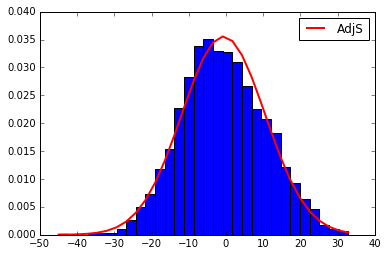

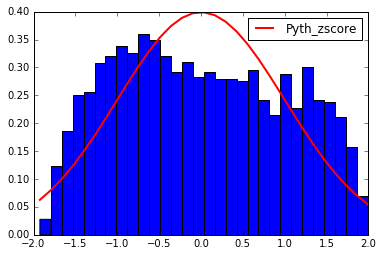

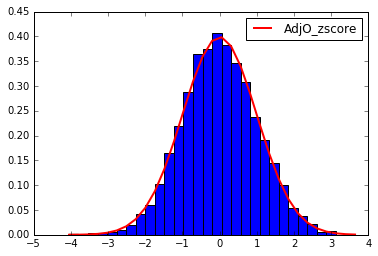

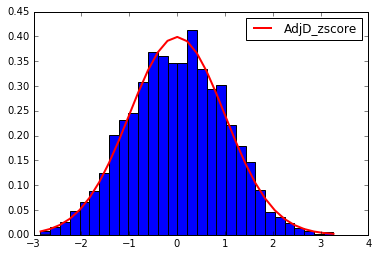

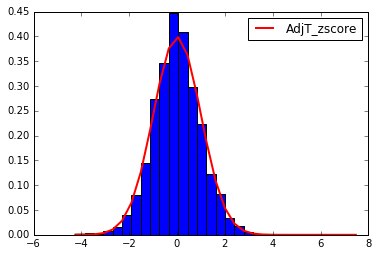

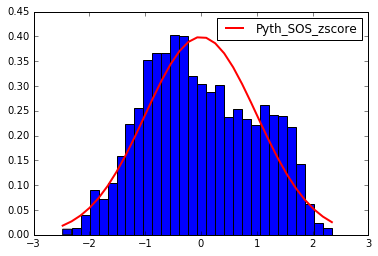

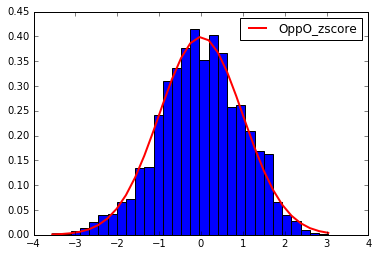

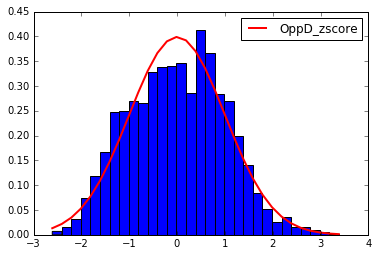

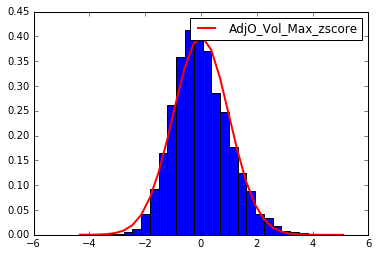

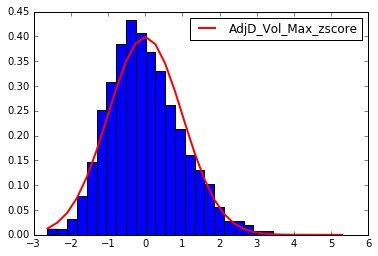

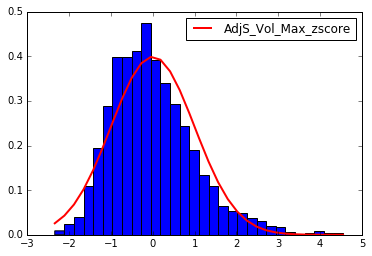

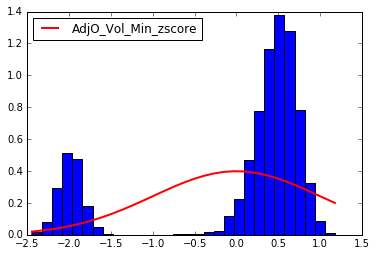

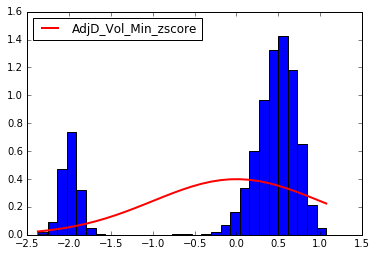

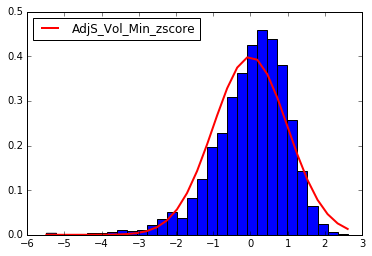

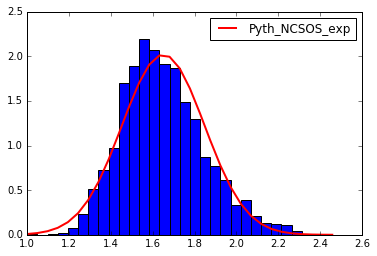

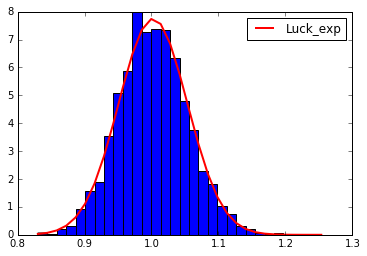

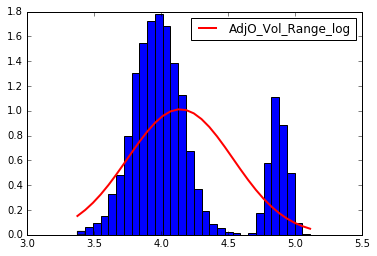

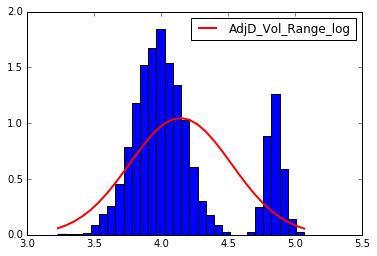

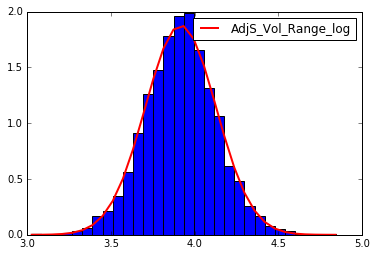

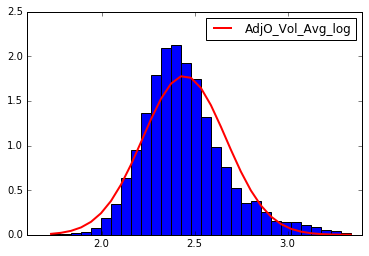

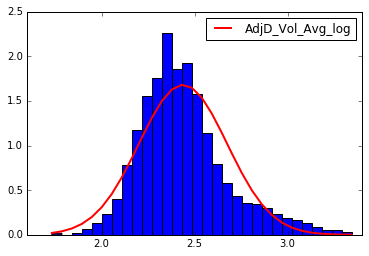

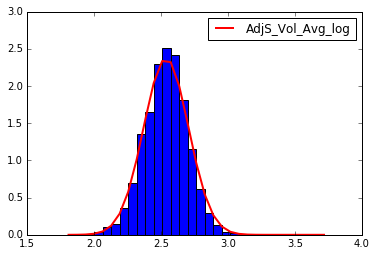

In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

kpGraph2 = kpMergeFinal
kpGraph2.drop('Team_Year', axis =1, inplace = True)
kpCol = list(kpGraph2.columns)
axes = plt.gca()

for column in kpGraph2:
    s = kpGraph2[column]
    mu = np.mean(kpGraph2[column])
    sigma = np.std(kpGraph2[column])
    count, bins, ignored = plt.hist(s, 30, normed=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2*np.pi)) *
       np.exp( - (bins - mu) ** 2 / (2 * sigma ** 2)),
       linewidth = 2, color = 'r', label=column)
    plt.legend(loc=0)
    plt.figure()
    
## NOTE MUST RERUN IN [130] before continuing to replace Team_Year. Need to figure out better way of 
## deleting team_year from these graphs, but not having to rerun code to replace it

In [39]:
## Model using difference between the two teams across all variables

regUse = regSeasonComp[['Wteam', 'Lteam', 'Home', 'Neutral', 'Away', 'Win']]
tourneyUse = tourneyResults[['Wteam', 'Lteam', 'Home', 'Neutral', 'Away', 'Win']]

allUse = pd.concat([regUse, tourneyUse])

kpModel = allUse.merge(kpMergeFinal, left_on = 'Wteam', right_on = 'Team_Year')
kpModel = kpModel.merge(kpMergeFinal, left_on = 'Lteam', right_on = 'Team_Year')

kpModel['Pyth_diff'] = kpModel['Pyth_zscore_x'] - kpModel['Pyth_zscore_y']
kpModel['AdjO_diff'] = kpModel['AdjO_zscore_x'] - kpModel['AdjO_zscore_y']
kpModel['AdjD_diff'] = kpModel['AdjD_zscore_x'] - kpModel['AdjD_zscore_y']
kpModel['AdjS_diff'] = kpModel['AdjS_zscore_x'] - kpModel['AdjS_zscore_y']
kpModel['AdjT_diff'] = kpModel['AdjT_zscore_x'] - kpModel['AdjT_zscore_y']
kpModel['Luck_diff'] = kpModel['Luck_exp_x'] - kpModel['Luck_exp_y']
kpModel['Pyth_SOS_diff'] = kpModel['Pyth_SOS_zscore_x'] - kpModel['Pyth_SOS_zscore_y']
kpModel['OppO_diff'] = kpModel['OppO_zscore_x'] - kpModel['OppO_zscore_y']
kpModel['OppD_diff'] = kpModel['OppD_zscore_x'] - kpModel['OppD_zscore_y']
kpModel['Pyth_NCSOS_diff'] = kpModel['Pyth_NCSOS_exp_x'] - kpModel['Pyth_NCSOS_exp_y']
kpModel['AdjO_Vol_Max_diff'] = kpModel['AdjO_Vol_Max_zscore_x'] - kpModel['AdjO_Vol_Max_zscore_y']
kpModel['AdjD_Vol_Max_diff'] = kpModel['AdjD_Vol_Max_zscore_x'] - kpModel['AdjD_Vol_Max_zscore_y']
kpModel['AdjS_Vol_Max_diff'] = kpModel['AdjS_Vol_Max_zscore_x'] - kpModel['AdjS_Vol_Max_zscore_y']
kpModel['AdjO_Vol_Min_diff'] = kpModel['AdjO_Vol_Min_zscore_x'] - kpModel['AdjO_Vol_Min_zscore_y']
kpModel['AdjD_Vol_Min_diff'] = kpModel['AdjD_Vol_Min_zscore_x'] - kpModel['AdjD_Vol_Min_zscore_y']
kpModel['AdjS_Vol_Min_diff'] = kpModel['AdjS_Vol_Min_zscore_x'] - kpModel['AdjS_Vol_Min_zscore_y']
kpModel['AdjO_Vol_Range_diff'] = kpModel['AdjO_Vol_Range_log_x'] - kpModel['AdjO_Vol_Range_log_y']
kpModel['AdjD_Vol_Range_diff'] = kpModel['AdjD_Vol_Range_log_x'] - kpModel['AdjD_Vol_Range_log_y']
kpModel['AdjS_Vol_Range_diff'] = kpModel['AdjS_Vol_Range_log_x'] - kpModel['AdjS_Vol_Range_log_y']
kpModel['AdjO_Vol_Avg_diff'] = kpModel['AdjO_Vol_Avg_log_x'] - kpModel['AdjO_Vol_Avg_log_y']
kpModel['AdjD_Vol_Avg_diff'] = kpModel['AdjD_Vol_Avg_log_x'] - kpModel['AdjD_Vol_Avg_log_y']
kpModel['AdjS_Vol_Avg_diff'] = kpModel['AdjS_Vol_Avg_log_x'] - kpModel['AdjS_Vol_Avg_log_y']

kpModel['id'] = kpModel.Wteam.str[:4] + '_' + kpModel.Wteam.str[4:] + '_' + kpModel.Lteam.str[4:]

kpFinal = kpModel.iloc[:,[2,3,4,5,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74]]
Target = 'Win'
IDcol = 'id'
kpFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133124 entries, 0 to 133123
Data columns (total 27 columns):
Home                   133124 non-null int64
Neutral                133124 non-null int64
Away                   133124 non-null int64
Win                    133124 non-null int64
Pyth_diff              133124 non-null float64
AdjO_diff              133124 non-null float64
AdjD_diff              133124 non-null float64
AdjS_diff              133124 non-null float64
AdjT_diff              133124 non-null float64
Luck_diff              133124 non-null float64
Pyth_SOS_diff          133124 non-null float64
OppO_diff              133124 non-null float64
OppD_diff              133124 non-null float64
Pyth_NCSOS_diff        133124 non-null float64
AdjO_Vol_Max_diff      133124 non-null float64
AdjD_Vol_Max_diff      133124 non-null float64
AdjS_Vol_Max_diff      133124 non-null float64
AdjO_Vol_Min_diff      133124 non-null float64
AdjD_Vol_Min_diff      133124 non-null float64
AdjS

In [41]:
%matplotlib inline
import matplotlib as plt
import sklearn.ensemble as ens
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

tIndex = np.random.rand(len(kpFinal)) < 0.75
X_train = kpFinal[tIndex]
X_test = kpFinal[~tIndex]
X_testWin = pd.DataFrame({'Win': X_test['Win'],
                         'id': X_test['id']})

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds =5):
    ## Fit algorithm to the data
    alg.fit(dtrain[predictors], dtrain['Win'])
    ## Predict Training Set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob=alg.predict_proba(dtrain[predictors])[:,1]
    ## Perform Cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Win'], 
                                                    cv=cv_folds, scoring = 'roc_auc')
    ## Print model report
    print("\nModel Report")
    print("Accuracy: %.4g" % metrics.accuracy_score(dtrain['Win'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Win'], dtrain_predprob))
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
        % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
        
    ## Print Feature Importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature_Importances')
        plt.ylabel('Feature_Importance_Score')
        
predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

#param_test1 = {'n_estimators': [50, 75, 100]}
#gSearch1 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth =5 , learning_rate = 0.1, min_samples_split = 500,
#                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
#                                         random_state = 10),
#param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
#gSearch1.fit(X_train[predictors],X_train[Target])
#modelfit(gSearch1, X_train, predictors)


In [179]:
## Grid Search for number of estimators

predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

param_test1 = {'n_estimators': [100, 200, 300]}
gSearch1 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth =5 , learning_rate = 0.1, min_samples_split = 500,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                         random_state = 10),
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gSearch1.fit(X_train[predictors],X_train[Target])
modelfit(gSearch1, X_train, predictors)
xgSearch1.grid_scores_, gSearch1.best_params_, gSearch1.best_score_


Model Report
Accuracy: 0.7764
AUC Score (Train): 0.866042
CV Score : Mean - 0.8484722 | Std - 0.003092657 | Min - 0.8448466 | Max - 0.85372


AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [181]:
## Grid Search for learning_rate

predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

param_test1 = {'learning_rate': [.05, .1, .15]}
gSearch2 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth = 5 , n_estimators =250, min_samples_split = 500,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                          random_state = 10),
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gSearch2.fit(X_train[predictors],X_train[Target])
modelfit(gSearch2, X_train, predictors)


Model Report
Accuracy: 0.7742
AUC Score (Train): 0.863558
CV Score : Mean - 0.8482659 | Std - 0.003085846 | Min - 0.844647 | Max - 0.8536199


AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [185]:
## Grid Search for min_samples_split

predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

param_test1 = {'min_samples_split': [250, 500, 750]}
gSearch3 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth = 5 , n_estimators =50, learning_rate = .1,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                          random_state = 10),
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gSearch3.fit(X_train[predictors],X_train[Target])
modelfit(gSearch3, X_train, predictors)


Model Report
Accuracy: 0.7647
AUC Score (Train): 0.851611
CV Score : Mean - 0.8455392 | Std - 0.003059621 | Min - 0.8420077 | Max - 0.8506527


AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [189]:
## Grid Search for max_depth

predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

param_test4 = {'max_depth': [3, 5, 7]}
gSearch4 = GridSearchCV(estimator = ens.GradientBoostingClassifier(min_samples_split = 250, n_estimators =50, learning_rate = .1,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                          random_state = 10),
param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gSearch4.fit(X_train[predictors],X_train[Target])
modelfit(gSearch4, X_train, predictors)


Model Report
Accuracy: 0.7702
AUC Score (Train): 0.859492
CV Score : Mean - 0.8471678 | Std - 0.00315474 | Min - 0.8434622 | Max - 0.8525699


AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [190]:
gSearch4.grid_scores_, gSearch4.best_params_, gSearch4.best_score_

([mean: 0.84168, std: 0.00323, params: {'max_depth': 3},
  mean: 0.84570, std: 0.00302, params: {'max_depth': 5},
  mean: 0.84717, std: 0.00315, params: {'max_depth': 7}],
 {'max_depth': 7},
 0.84716775010196455)


Model Report
Accuracy: 0.7958
AUC Score (Train): 0.887097


AttributeError: module 'matplotlib' has no attribute 'ylabel'

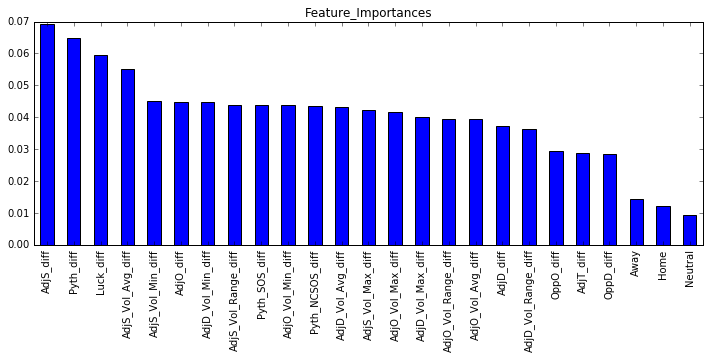

In [42]:
gbmFin = ens.GradientBoostingClassifier(max_depth = 7 , learning_rate = 0.025, min_samples_split = 250,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                         random_state = 10, n_estimators = 1000)
modelfit(gbmFin, X_train, predictors, performCV = False, printFeatureImportance = True)

In [61]:
import xgboost as xgb

xgb1 = xgb.XGBClassifier(max_depth =5 , learning_rate = 0.1, n_estimators = 100,
                                    subsample= .85, colsample_bytree =.85, 
                                     objective = 'binary:logistic').fit(X_train, y_train)


In [71]:
X_test.drop(['id','Win'],inplace=True,axis=1,errors='ignore')

predTest = gbmFin.predict_proba(X_test)
predTestComp = pd.DataFrame({'pred' : predTest[:,1],
                             'Win': X_testWin['Win']})

predTestComp['predRound'] = np.round(predTestComp['pred'], decimals=2) # Round prediction % for ease of interpretation
predTestComp['diff'] = abs(predTestComp['Win'] - predTestComp['pred'])
predTestComp['bin'] = 0
def f(df):
    if df['diff'] < 0.5:
        val = 1
    else:
        val = 0
    return val

predTestComp['bin'] = predTestComp.apply(f, axis=1)
predTestComp.head(n=10)
grouped = predTestComp.groupby(['predRound'])['Win'].agg(['mean', 'sum', 'count']).reset_index()
groupedPred = predTestComp.groupby(['predRound'])['bin'].agg(['mean', 'sum', 'count'])

/Users/Wesley/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,predRound,mean,sum,count
0,0.00,0.000000,0,78
1,0.01,0.002915,2,686
2,0.02,0.009901,6,606
3,0.03,0.033203,17,512
4,0.04,0.029018,13,448


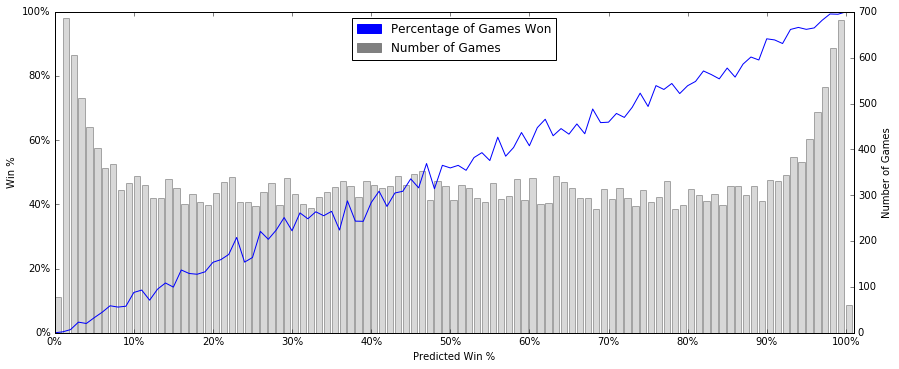

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Purpose of this chart is to get an understanding of how predicted probabilities translate to actual wins
## As well as an understanding of the prediction distribution across percentages

## NOTE - in order to run this need to have a completed model, then create a dataframe 
## that contains the predicted chance of winning & actual outcome for each game in the test set

## Create dataframe with predicted win % and actual result for each game from predicted test set
## predTest DataFrame houses my predictions, and X_testWin houses the outcome of the predicted games

predTestComp = pd.DataFrame({'pred' : predTest[:,1],
                             'Win': X_testWin['Win']})


## Round prediction % for ease of interpretation

predTestComp['predRound'] = np.round(predTestComp['pred'], decimals=2) 

## Group predictions by predicted win percentage, then find the total number of wins, games & average win percentage 
## For each rounded prediction value (0-100%)

grouped = predTestComp.groupby(['predRound'])['Win'].agg(['sum', 'count', 'mean']).reset_index()

## Create subplots that have win% on the x axis, and number of games on the secondary axis

fig, tsax = plt.subplots(figsize=(12,5))
barax = tsax.twinx()

## Create bar chart based on the count of games for each predicted percentage

barax.bar(grouped.index, grouped['count'], facecolor=(0.5, 0.5, 0.5), alpha=0.3) 

## Create line chart that shows the average win percentage by predicted percentage

fig.tight_layout()
tsax.plot(grouped.index, grouped['mean'], color = 'b')

## Set axis & data point labels as well as tick distribution

barax.set_ylabel('Number of Games')
barax.xaxis.tick_top()
tsax.set_ylabel('Win %')
tsax.set_xlabel('Predicted Win %')
tsax.set_xlim([0, 101])
tsax.set_ylim([0, 1])
plt.xticks(np.arange(0, 101, 10))
percListX = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
percListY = ['0%', '20%', '40%', '60%', '80%', '100%']
tsax.set_xticklabels(percListX)
tsax.set_yticklabels(percListY)

## Put line graph in front of bar chart

tsax.set_zorder(barax.get_zorder()+1) 
tsax.patch.set_visible(False) # hide the 'canvas' 

## Create legend labels - necessary because it's a subplot

line_patch = mpatches.Patch(color='blue', label='Percentage of Games Won')
bar_patch = mpatches.Patch(color='gray', label='Number of Games')
plt.legend(handles=[line_patch, bar_patch], loc = 'upper center')
plt.savefig('output.png', dpi=300)

In [43]:
## Test Predictor


kpModelStage1 = stage1.merge(kpMergeFinal, left_on = 'Wteam', right_on = 'Team_Year')
kpModelStage1 = kpModelStage1.merge(kpMergeFinal, left_on = 'Lteam', right_on = 'Team_Year')

kpModelStage1['Pyth_diff'] = kpModelStage1['Pyth_zscore_x'] - kpModelStage1['Pyth_zscore_y']
kpModelStage1['AdjO_diff'] = kpModelStage1['AdjO_zscore_x'] - kpModelStage1['AdjO_zscore_y']
kpModelStage1['AdjD_diff'] = kpModelStage1['AdjD_zscore_x'] - kpModelStage1['AdjD_zscore_y']
kpModelStage1['AdjS_diff'] = kpModelStage1['AdjS_zscore_x'] - kpModelStage1['AdjS_zscore_y']
kpModelStage1['AdjT_diff'] = kpModelStage1['AdjT_zscore_x'] - kpModelStage1['AdjT_zscore_y']
kpModelStage1['Luck_diff'] = kpModelStage1['Luck_exp_x'] - kpModelStage1['Luck_exp_y']
kpModelStage1['Pyth_SOS_diff'] = kpModelStage1['Pyth_SOS_zscore_x'] - kpModelStage1['Pyth_SOS_zscore_y']
kpModelStage1['OppO_diff'] = kpModelStage1['OppO_zscore_x'] - kpModelStage1['OppO_zscore_y']
kpModelStage1['OppD_diff'] = kpModelStage1['OppD_zscore_x'] - kpModelStage1['OppD_zscore_y']
kpModelStage1['Pyth_NCSOS_diff'] = kpModelStage1['Pyth_NCSOS_exp_x'] - kpModelStage1['Pyth_NCSOS_exp_y']
kpModelStage1['AdjO_Vol_Max_diff'] = kpModelStage1['AdjO_Vol_Max_zscore_x'] - kpModelStage1['AdjO_Vol_Max_zscore_y']
kpModelStage1['AdjD_Vol_Max_diff'] = kpModelStage1['AdjD_Vol_Max_zscore_x'] - kpModelStage1['AdjD_Vol_Max_zscore_y']
kpModelStage1['AdjS_Vol_Max_diff'] = kpModelStage1['AdjS_Vol_Max_zscore_x'] - kpModelStage1['AdjS_Vol_Max_zscore_y']
kpModelStage1['AdjO_Vol_Min_diff'] = kpModelStage1['AdjO_Vol_Min_zscore_x'] - kpModelStage1['AdjO_Vol_Min_zscore_y']
kpModelStage1['AdjD_Vol_Min_diff'] = kpModelStage1['AdjD_Vol_Min_zscore_x'] - kpModelStage1['AdjD_Vol_Min_zscore_y']
kpModelStage1['AdjS_Vol_Min_diff'] = kpModelStage1['AdjS_Vol_Min_zscore_x'] - kpModelStage1['AdjS_Vol_Min_zscore_y']
kpModelStage1['AdjO_Vol_Range_diff'] = kpModelStage1['AdjO_Vol_Range_log_x'] - kpModelStage1['AdjO_Vol_Range_log_y']
kpModelStage1['AdjD_Vol_Range_diff'] = kpModelStage1['AdjD_Vol_Range_log_x'] - kpModelStage1['AdjD_Vol_Range_log_y']
kpModelStage1['AdjS_Vol_Range_diff'] = kpModelStage1['AdjS_Vol_Range_log_x'] - kpModelStage1['AdjS_Vol_Range_log_y']
kpModelStage1['AdjO_Vol_Avg_diff'] = kpModelStage1['AdjO_Vol_Avg_log_x'] - kpModelStage1['AdjO_Vol_Avg_log_y']
kpModelStage1['AdjD_Vol_Avg_diff'] = kpModelStage1['AdjD_Vol_Avg_log_x'] - kpModelStage1['AdjD_Vol_Avg_log_y']
kpModelStage1['AdjS_Vol_Avg_diff'] = kpModelStage1['AdjS_Vol_Avg_log_x'] - kpModelStage1['AdjS_Vol_Avg_log_y']

kpModelStage1['id'] = kpModelStage1.Wteam.str[:4] + '_' + kpModelStage1.Wteam.str[4:] + '_' + kpModelStage1.Lteam.str[4:]
kpFinalStage1 = kpModelStage1.iloc[:,[2,3,4,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72]]

In [44]:
import os


X_testStage1 = kpFinalStage1

predSub = gbmFin.predict_proba(X_testStage1)
#predSub2 = xgb1.predict_proba(X_testStage1)

submission = pd.DataFrame({'id': kpModelStage1['id'],
                           'pred' : predSub[:,1]})
#submission2 = pd.DataFrame({'id': kpModelStage1['id'],
#                          'pred' : predSub2[:,1]})

path = '/Users/Wesley/Documents/Kaggle/MarchMadness'
os.chdir(path)

submission.to_csv('gbmSubmission.csv')
#submission2.to_csv('xgbSubmission.csv')

